<a href="https://colab.research.google.com/github/k-vinamr/rera_construction_pred/blob/main/31_oct_7_floor_augmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display
import statsmodels as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split,GridSearchCV,RandomizedSearchCV
from sklearn.linear_model import LinearRegression,Ridge,Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor,GradientBoostingRegressor
from sklearn.metrics import r2_score,mean_squared_error
from sklearn import preprocessing
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from datetime import datetime

In [2]:
data = pd.read_excel('7_floor_data.xlsx')

In [3]:
data.head()


,organisation_name,project_category,actual_commencement_date,estimated_finish_date,total_built_up_area_saleable_area,total_area_of_project,floor,project_state,total_days,percentage,...,7th floor Columns casting,7th Floor slab casting,Brickwork of 5th to 7th Floor,"Electrical concealed, PVC Fitting, plastering at 4th-7th floor",Plastering on outer sides,Tiles work,Painting and Finishing,"Plumbing & Sanitary,Electrification Works",Doors & Windows Fixing Furniture work,other work
0,NAKSHATRA BUILDERS & DEVELOPERS,Residential/Group Housing,2017-08-14,2017-11-15,2214.08,1341.87,7,MAHARASHTRA,93,0.004985,...,1.205384,2.03988,3.245264,4.821535,6.954138,8.344965,8.344965,5.56331,8.344965,2.781655
1,KRISHNA BHOORARAM PUROHIT,Residential/Group Housing,2021-09-09,2021-12-30,821.67,442.20,7,MAHARASHTRA,112,0.027916,...,1.451645,2.45663,3.908275,5.806580,8.374875,10.049850,10.049850,6.69990,10.049850,3.349950
2,Sudarshan Realities,Residential/Group Housing,2021-09-09,2021-12-30,704.30,507.24,7,MAHARASHTRA,112,0.029910,...,1.451645,2.45663,3.908275,5.806580,8.374875,10.049850,10.049850,6.69990,10.049850,3.349950
3,Sai Reality,Residential/Group Housing,2021-09-09,2021-12-30,886.60,513.75,7,MAHARASHTRA,112,0.014955,...,1.451645,2.45663,3.908275,5.806580,8.374875,10.049850,10.049850,6.69990,10.049850,3.349950
4,SAGAR DEVELOPERS,Residential/Group Housing,2021-09-09,2021-12-30,700.00,538.17,7,MAHARASHTRA,112,0.017946,...,1.451645,2.45663,3.908275,5.806580,8.374875,10.049850,10.049850,6.69990,10.049850,3.349950


In [4]:
# Converting date columns to datetime objects
data['actual_commencement_date'] = pd.to_datetime(data['actual_commencement_date'], format='%d-%m-%Y', errors='coerce')
data['estimated_finish_date'] = pd.to_datetime(data['estimated_finish_date'], format='%d-%m-%Y', errors='coerce')


In [5]:
current_date = datetime.now()

In [6]:
data['duration_since_commencement'] = (current_date - data['actual_commencement_date']).dt.days
data['remaining_duration'] = (data['estimated_finish_date'] - current_date).dt.days
data['progress_ratio'] = data['duration_since_commencement'] / data['total_days']

In [7]:
# Define a function to determine the project status
def determine_status(row):
    if current_date > row['estimated_finish_date']:
        return 'completed'
    elif current_date >= row['actual_commencement_date']:
        return 'running'
    else:
        return 'upcoming'

# Apply the function to create the 'Status' column
data['current_stage'] = data.apply(determine_status, axis=1)

# Print the DataFrame with the 'Status' column
data


,organisation_name,project_category,actual_commencement_date,estimated_finish_date,total_built_up_area_saleable_area,total_area_of_project,floor,project_state,total_days,percentage,...,Plastering on outer sides,Tiles work,Painting and Finishing,"Plumbing & Sanitary,Electrification Works",Doors & Windows Fixing Furniture work,other work,duration_since_commencement,remaining_duration,progress_ratio,current_stage
0,NAKSHATRA BUILDERS & DEVELOPERS,Residential/Group Housing,2017-08-14,2017-11-15,2214.08,1341.87,7,MAHARASHTRA,93,0.004985,...,6.954138,8.344965,8.344965,5.563310,8.344965,2.781655,2269,-2177,24.397849,completed
1,KRISHNA BHOORARAM PUROHIT,Residential/Group Housing,2021-09-09,2021-12-30,821.67,442.20,7,MAHARASHTRA,112,0.027916,...,8.374875,10.049850,10.049850,6.699900,10.049850,3.349950,782,-671,6.982143,completed
2,Sudarshan Realities,Residential/Group Housing,2021-09-09,2021-12-30,704.30,507.24,7,MAHARASHTRA,112,0.029910,...,8.374875,10.049850,10.049850,6.699900,10.049850,3.349950,782,-671,6.982143,completed
3,Sai Reality,Residential/Group Housing,2021-09-09,2021-12-30,886.60,513.75,7,MAHARASHTRA,112,0.014955,...,8.374875,10.049850,10.049850,6.699900,10.049850,3.349950,782,-671,6.982143,completed
4,SAGAR DEVELOPERS,Residential/Group Housing,2021-09-09,2021-12-30,700.00,538.17,7,MAHARASHTRA,112,0.017946,...,8.374875,10.049850,10.049850,6.699900,10.049850,3.349950,782,-671,6.982143,completed
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1118,Patil Shah Housing,Residential/Group Housing,2022-10-09,2030-12-31,3043.99,1703.86,7,MAHARASHTRA,3005,NaN,...,224.700897,269.641077,269.641077,179.760718,269.641077,89.880359,387,2617,0.128785,running
1119,SAI RYDAM REALTORS PVT LTD,Residential/Group Housing,2021-09-09,2029-12-30,3294.31,11661.00,7,MAHARASHTRA,3034,NaN,...,226.869392,272.243270,272.243270,181.495513,272.243270,90.747757,782,2251,0.257746,running
1120,AAKAR BUILDERS,Residential/Group Housing,2021-09-13,2030-03-31,8312.00,7702.00,7,MAHARASHTRA,3121,NaN,...,233.374875,280.049850,280.049850,186.699900,280.049850,93.349950,778,2342,0.249279,running
1121,JHALAK CONSTRUCTIONS,Residential/Group Housing,2022-11-28,2031-12-31,6157.89,2265.00,7,MAHARASHTRA,3320,NaN,...,248.255234,297.906281,297.906281,198.604187,297.906281,99.302094,337,2982,0.101506,running


In [8]:
# Assuming you have your data in a DataFrame named df
# If it's not, you can read your data from a CSV or any other source

# Define the bin edges
bin_width = 500
max_value = int(data['total_built_up_area_saleable_area'].max())
bin_edges = list(range(0, max_value + bin_width, bin_width))  # Creates bins of size 500

# Create a new column to store the bin labels
data['area_bin'] = pd.cut(data['total_built_up_area_saleable_area'], bin_edges)

# Group the data by the 'area_bin' column
grouped = data.groupby('area_bin')

# Define the features you want to analyze
features = ['total_days']  # Add more features as needed

# Iterate over the groups and calculate min and max for each feature
for feature in features:
    data_min = grouped[feature].min()
    data_max = grouped[feature].max()
    data_mean = grouped[feature].mean()
    data_count = grouped[feature].count()
    result = pd.concat([data_min, data_max, data_mean, data_count], axis=1)
    result.columns = ['Min', 'Max', 'Mean', 'Count']
    print(f"Statistics for '{feature}':")
    print(result)
    print("\n")

Statistics for 'total_days':
                   Min     Max         Mean  Count
area_bin                                          
(0, 500]         135.0  1988.0   706.317073     41
(500, 1000]      112.0  2298.0   791.602740    219
(1000, 1500]     112.0  2378.0   852.596078    255
(1500, 2000]     125.0  2846.0  1010.062857    175
(2000, 2500]      93.0  2313.0   923.288462    104
...                ...     ...          ...    ...
(37500, 38000]     NaN     NaN          NaN      0
(38000, 38500]     NaN     NaN          NaN      0
(38500, 39000]     NaN     NaN          NaN      0
(39000, 39500]     NaN     NaN          NaN      0
(39500, 40000]  1538.0  1538.0  1538.000000      1

[80 rows x 4 columns]




In [9]:
# Filter the DataFrame based on the condition
filtered_data = data[data['total_built_up_area_saleable_area'] < 30000]

In [10]:
# Assuming you have your data in a DataFrame named df
# If it's not, you can read your data from a CSV or any other source

# Define the bin edges
bin_width = 500
max_value = int(filtered_data['total_built_up_area_saleable_area'].max())
bin_edges = list(range(0, max_value + bin_width, bin_width))  # Creates bins of size 500

# Create a new column to store the bin labels
filtered_data['area_bin'] = pd.cut(filtered_data['total_built_up_area_saleable_area'], bin_edges)

# Group the data by the 'area_bin' column
grouped = filtered_data.groupby('area_bin')

# Define the features you want to analyze
features = ['total_days']  # Add more features as needed

# Iterate over the groups and calculate min and max for each feature
for feature in features:
    filtered_data_min = grouped[feature].min()
    filtered_data_max = grouped[feature].max()
    filtered_data_mean = grouped[feature].mean()
    filtered_data_count = grouped[feature].count()
    result = pd.concat([filtered_data_min, filtered_data_max, filtered_data_mean, filtered_data_count], axis=1)
    result.columns = ['Min', 'Max', 'Mean', 'Count']
    print(f"Statistics for '{feature}':")
    print(result)
    print("\n")

Statistics for 'total_days':
                   Min     Max         Mean  Count
area_bin                                          
(0, 500]         135.0  1988.0   706.317073     41
(500, 1000]      112.0  2298.0   791.602740    219
(1000, 1500]     112.0  2378.0   852.596078    255
(1500, 2000]     125.0  2846.0  1010.062857    175
(2000, 2500]      93.0  2313.0   923.288462    104
(2500, 3000]     147.0  2854.0   989.224719     89
(3000, 3500]     112.0  3034.0  1117.857143     63
(3500, 4000]     112.0  3375.0  1214.000000     30
(4000, 4500]     227.0  2018.0   974.250000     28
(4500, 5000]     500.0  2481.0  1221.846154     13
(5000, 5500]     129.0  2147.0  1249.052632     19
(5500, 6000]     311.0  2139.0  1258.000000      9
(6000, 6500]     963.0  3320.0  1492.818182     11
(6500, 7000]     938.0  1765.0  1395.166667      6
(7000, 7500]     899.0  2257.0  1582.125000      8
(7500, 8000]    1036.0  2269.0  1380.600000      5
(8000, 8500]    1354.0  3121.0  1842.666667      6
(8

<ipython-input-10-3ac3ef85beec>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['area_bin'] = pd.cut(filtered_data['total_built_up_area_saleable_area'], bin_edges)


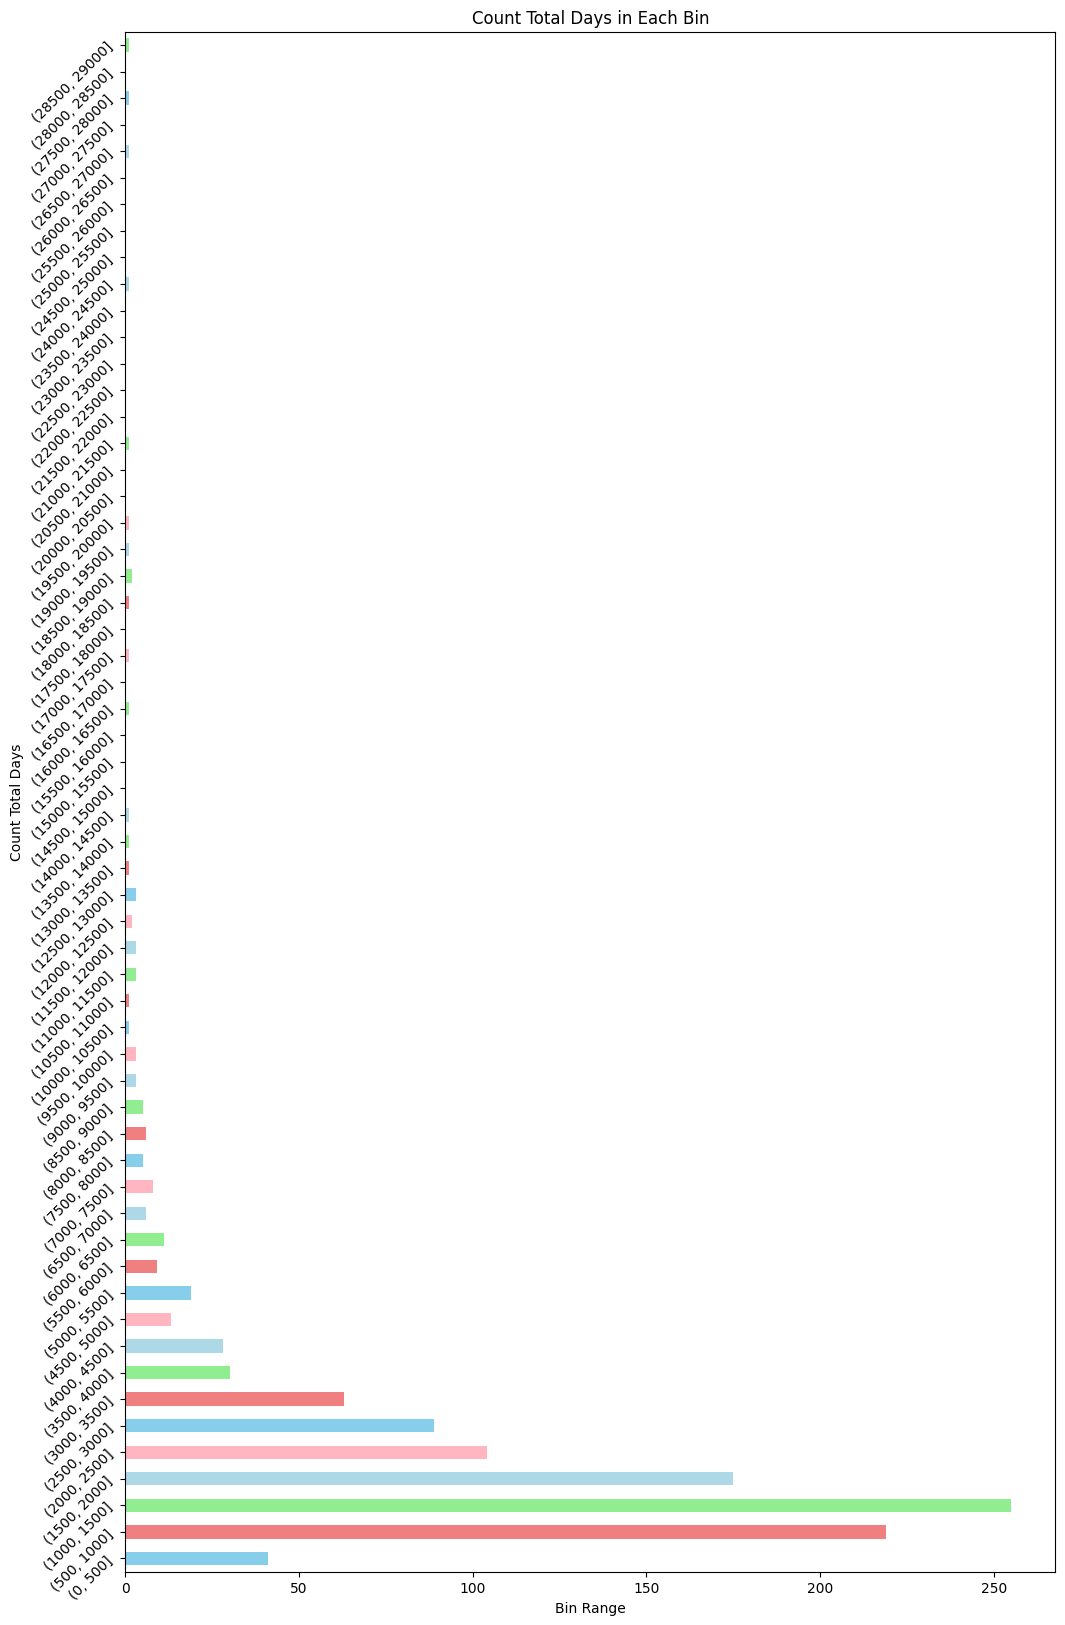

In [11]:
# Create a bar chart for the mean values
colors = ['skyblue', 'lightcoral', 'lightgreen', 'lightblue', 'lightpink']
plt.figure(figsize=(12, 20))
filtered_data_count.plot(kind='barh', color=colors)
plt.xlabel('Bin Range')
plt.ylabel('Count Total Days')
plt.title('Count Total Days in Each Bin')
plt.yticks(range(len(filtered_data_count)), filtered_data_count.index, rotation=45)
plt.show()


In [12]:
import pandas as pd
import random
from datetime import timedelta

# Assuming you have your filtered data in a DataFrame named filtered_df
# Ensure you have loaded the necessary libraries and data

# Define the number of data points you want to generate
desired_data_points = 10000  # Change this number as needed

# Create an empty DataFrame to store the augmented data
augmented_data = pd.DataFrame(columns=filtered_data.columns)

# Copy the original data to the augmented DataFrame
augmented_data = augmented_data.append(filtered_data, ignore_index=True)

# Define the range for small changes (you can adjust this)
date_change_range = 7  # Number of days for date changes
area_change_range = 10  # Range for changing area

# Generate additional data points
while len(augmented_data) < desired_data_points:
    # Randomly select an existing row to modify
    index_to_modify = random.randint(0, len(filtered_data) - 1)
    row_to_modify = augmented_data.iloc[index_to_modify].copy()

    # Make small changes to the selected row
    row_to_modify['actual_commencement_date'] += timedelta(days=random.randint(-date_change_range, date_change_range))
    row_to_modify['estimated_finish_date'] += timedelta(days=random.randint(-date_change_range, date_change_range))
    row_to_modify['total_built_up_area_saleable_area'] += random.uniform(-area_change_range, area_change_range)
    row_to_modify['total_area_of_project'] += random.uniform(-area_change_range, area_change_range)

    # Add the modified row to the augmented DataFrame
    augmented_data = augmented_data.append(row_to_modify, ignore_index=True)

    # You may want to truncate the DataFrame to the desired number of data points
    augmented_data = augmented_data[:desired_data_points]

    # Now, augmented_data contains the augmented data with the specified changes

Streaming output truncated to the last 5000 lines.
<ipython-input-12-b5558fb047dd>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  augmented_data = augmented_data.append(row_to_modify, ignore_index=True)
<ipython-input-12-b5558fb047dd>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  augmented_data = augmented_data.append(row_to_modify, ignore_index=True)
<ipython-input-12-b5558fb047dd>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  augmented_data = augmented_data.append(row_to_modify, ignore_index=True)
<ipython-input-12-b5558fb047dd>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  augmented_data = augmented_data.append(row_to_

In [13]:
# Define the bin edges
bin_width = 500
max_value = int(augmented_data['total_built_up_area_saleable_area'].max())
bin_edges = list(range(0, max_value + bin_width, bin_width))  # Creates bins of size 500

# Create a new column to store the bin labels
augmented_data['area_bin'] = pd.cut(augmented_data['total_built_up_area_saleable_area'], bin_edges)

# Group the data by the 'area_bin' column
grouped = augmented_data.groupby('area_bin')

# Define the features you want to analyze
features = ['total_days']  # Add more features as needed

# Iterate over the groups and calculate min and max for each feature
for feature in features:
    augmented_data_min = grouped[feature].min()
    augmented_data_max = grouped[feature].max()
    augmented_data_mean = grouped[feature].mean()
    augmented_data_count = grouped[feature].count()
    result = pd.concat([augmented_data_min, augmented_data_max, augmented_data_mean, augmented_data_count], axis=1)
    result.columns = ['Min', 'Max', 'Mean', 'Count']
    print(f"Statistics for '{feature}':")
    print(result)
    print("\n")

Statistics for 'total_days':
                   Min     Max         Mean  Count
area_bin                                          
(0, 500]         135.0  1988.0   715.351064    376
(500, 1000]      112.0  2298.0   780.606771   1920
(1000, 1500]     112.0  2378.0   842.392287   2256
(1500, 2000]     125.0  2846.0  1004.651663   1533
(2000, 2500]      93.0  2313.0   910.716511    963
(2500, 3000]     147.0  2854.0  1007.878049    820
(3000, 3500]     112.0  3034.0  1134.584699    549
(3500, 4000]     112.0  3375.0  1174.623693    287
(4000, 4500]     227.0  2018.0   981.285156    256
(4500, 5000]     500.0  2481.0  1326.666667    114
(5000, 5500]     129.0  2147.0  1249.103448    174
(5500, 6000]     311.0  2139.0  1260.200000     60
(6000, 6500]     963.0  3320.0  1500.472527     91
(6500, 7000]     938.0  1765.0  1380.131148     61
(7000, 7500]     899.0  2257.0  1557.338462     65
(7500, 8000]    1036.0  2269.0  1443.277778     54
(8000, 8500]    1354.0  3121.0  1864.576923     52
(8

In [15]:
augmented_data.to_csv('augmented_7_floor.csv', index=False)